In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gillespy2
from scipy.optimize import minimize


In [4]:
def CLE(beta2, k2, n2, alpha, dt):
    x = [x0]
    for i in range(len(t) - 1):
        dxi = np.random.normal(0, 1, 3) 
        x_curr = x[-1]
        
        

        F = (
            
            beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2))) -
            alpha * x_curr)
        
        G = (
            
            np.sqrt(beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2)))) * dxi[1] +
            np.sqrt(alpha * x_curr) * dxi[2])
        
        x_next = x_curr + dt * F + np.sqrt(dt) * G

        x = np.hstack([x, x_next])
    return x


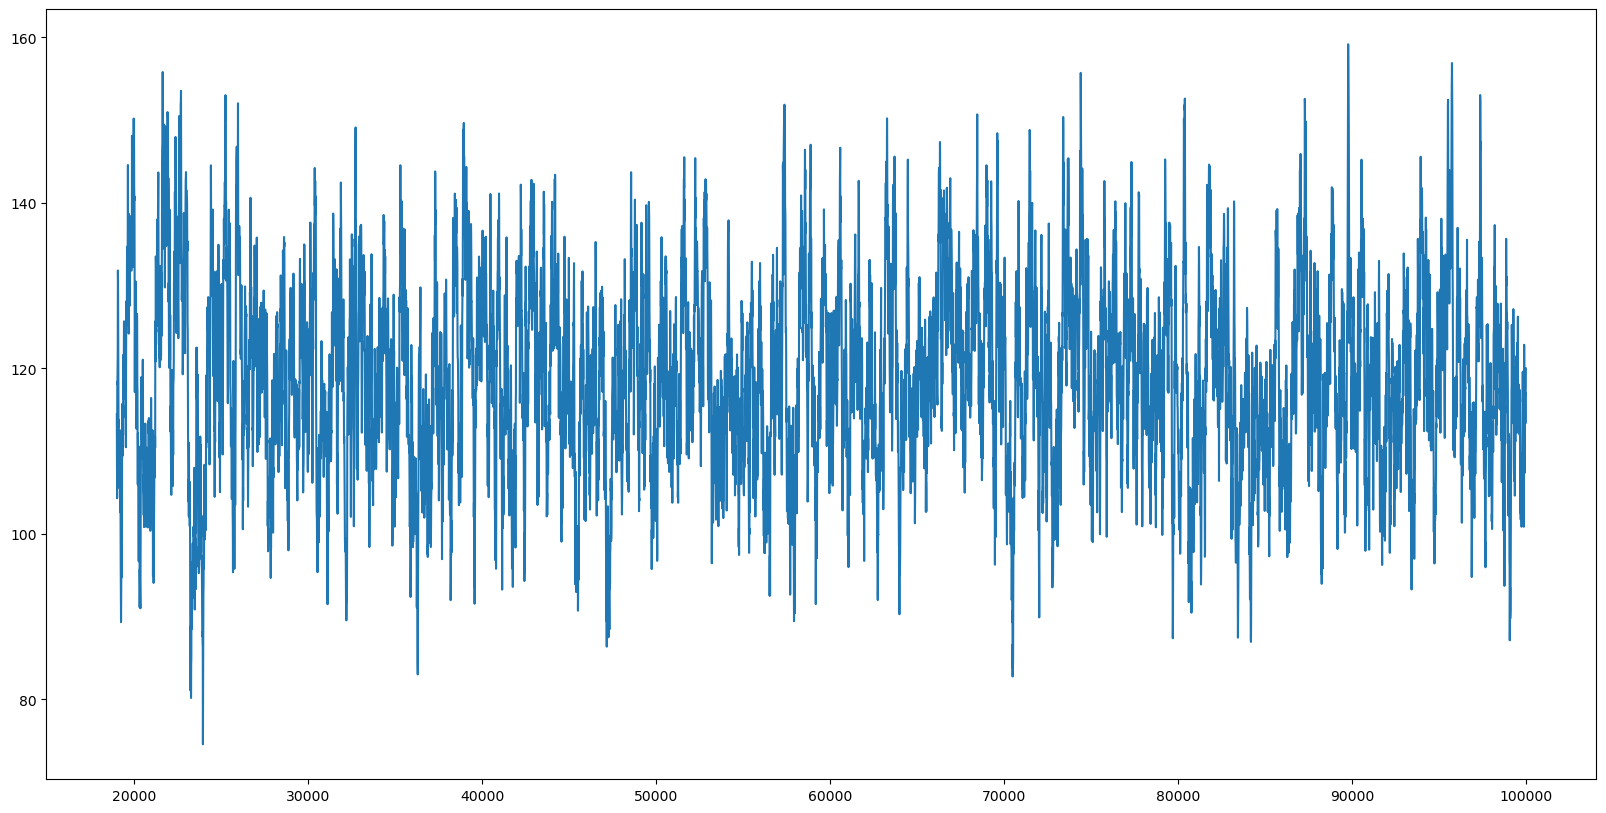

In [5]:

beta2=1.2
k2=1
n2=1
alpha=0.01
t = np.linspace(10000,100000,10000)
dt = t[1] - t[0]
x0=200
x_cle = CLE( beta2,k2, n2, alpha, dt)
x_cle_trimmed = x_cle[1000:]
t_trimmed = t[1000:]
plt.figure(figsize=(20, 10))
plt.plot(t_trimmed, x_cle_trimmed, label='cle')

In [6]:
def f_rep(x_cle_trimmed, k1, n1, beta1):
    return beta1 * (pow(k1, n1) / (pow(k1, n1) + pow(x_cle_trimmed, n1)))

def f_act(x_cle_trimmed, n2, k2, beta2):
    return beta2 * (pow(x_cle_trimmed, n2) / (pow(k2, n2) + pow(x_cle_trimmed, n2)))

def f_deg(x, alpha):
    return alpha * x_cle_trimmed

In [7]:
def fixed_point_act(x_cle_trimmed, k2, beta2, alpha):
    fact = f_act(x_cle_trimmed, n2, k2, beta2)
    fdeg = f_deg(x_cle_trimmed, alpha)
    
    diff_act = np.abs(fact - fdeg)
   
    fix_act_pt = x_cle_trimmed[np.where(diff_act < 0.005)[0][-1]]
   
    print('fix_act:', fix_act_pt)
   
    
    return fix_act_pt



In [8]:
from scipy.optimize import fixed_point

def fixed_point_rep(x_cle_trimmed, beta1, k1, n1, alpha):
    def equation_to_solve(x):
        frep = f_rep(x_cle_trimmed, k1, n1, beta1)
        fdeg = f_deg(x_cle_trimmed, alpha)
        return np.abs(frep - fdeg)

   
    initial_guess = np.mean(x_cle_trimmed)

   
    fix_rep_pt = fixed_point(equation_to_solve, initial_guess)

    print("fix_rep_pt:", fix_rep_pt)

   
       
        return None
  

In [9]:
fix_act_pt = fixed_point_act(x_cle_trimmed, k2, beta2, alpha)
#fix_rep_pt = fixed_point_rep(x_cle_trimmed, k1, beta1, alpha)


fix_act: 118.64123191885162


In [10]:
A=((-beta2*n2*pow(k2,n2)*pow(fix_act_pt,n2-1))/((pow(fix_act_pt,n2)+pow(k2,n2))**2))+alpha 
B=(beta2*pow(fix_act_pt,n2))/(pow(fix_act_pt,n2)+pow(k2,n2))+alpha*fix_act_pt

In [27]:
def A_r(fix_rep_pt, beta1, n1, K1, alpha):
    denominator = pow(fix_rep_pt, n1) + pow(K1, n1)
    
    numerator = beta1 * n1 * pow(K1, n1) * pow(fix_rep_pt, n1 - 1)
    result = (numerator / pow(denominator, 2)) + alpha
    
    #print("A_r result:", result, "numerator:", numerator, "denominator:", denominator)
    
    return result

def B_r(fix_rep_pt, beta1, n1, K1, alpha):
    denominator = pow(fix_rep_pt, n1) + pow(K1, n1)
    
    numerator = beta1 * pow(K1, n1)
    result = (numerator / denominator) + alpha * fix_rep_pt
    
    #print("B_r result:", result, "numerator:", numerator, "denominator:", denominator)
    
    return result


In [28]:
def cost_function(params, fix_act_pt, x_cle_trimmed, n2, k2, beta2, alpha,n1):
    beta1, K1 = params
    
    fix_rep_pt = fixed_point_rep(x_cle_trimmed, beta1, K1, n1, alpha)
    A = ((-beta2 * n2 * pow(k2, n2) * pow(fix_act_pt, n2 - 1)) / ((pow(fix_act_pt, n2) + pow(k2, n2))**2)) + alpha
    B = (beta2 * pow(fix_act_pt, n2)) / (pow(fix_act_pt, n2) + pow(k2, n2)) + alpha * fix_act_pt
    
   
    A_r_val = A_r(fix_rep_pt, beta1, n1, K1, alpha)
    B_r_val = B_r(fix_rep_pt, beta1, n1, K1, alpha)
    
    # Check for NaN values and return a large value
    if np.isnan(A_r_val) or np.isnan(B_r_val):
        return 1e6
    
    
    expression_diff = np.abs(B / (2 * A) - B_r_val / (2 * A_r_val)) + np.abs(fix_act_pt - fix_rep_pt)

    return np.sum(expression_diff)


In [29]:
 

# Set up the bounds
bounds_definition = [(0, None), (0, None)] 

# Initial guess for parameters (beta1, K1, n1)
n1=1
initial_guess = [0.1, 1]

result = minimize(cost_function, initial_guess, args=(fix_act_pt, x_cle_trimmed, n2, k2, beta2, alpha,n1),
                  method='trust-constr', tol=1e-6, options={'maxiter': 1000},
                  bounds=bounds_definition)

# Extract optimized parameters
optimized_params = result.x

# Print the optimized parameters
print("Optimized parameters (beta1, K1):", optimized_params)


fix_rep_pt: [1.14376272 1.08606059 1.04205624 ... 1.1746656  1.17647026 1.19900886]
fix_rep: [1.14376272 1.08606059 1.04205624 ... 1.1746656  1.17647026 1.19900886]
fix_rep_pt: [1.14376272 1.08606059 1.04205624 ... 1.1746656  1.17647026 1.19900886]
fix_rep: [1.14376272 1.08606059 1.04205624 ... 1.1746656  1.17647026 1.19900886]
fix_rep_pt: [1.14376272 1.08606059 1.04205624 ... 1.1746656  1.17647026 1.19900886]
fix_rep: [1.14376272 1.08606059 1.04205624 ... 1.1746656  1.17647026 1.19900886]
fix_rep_pt: [1.13242098 1.07412499 1.02962427 ... 1.16361824 1.16543962 1.18818287]
fix_rep: [1.13242098 1.07412499 1.02962427 ... 1.16361824 1.16543962 1.18818287]
fix_rep_pt: [1.13242098 1.07412499 1.02962427 ... 1.16361824 1.16543962 1.18818287]
fix_rep: [1.13242098 1.07412499 1.02962427 ... 1.16361824 1.16543962 1.18818287]
fix_rep_pt: [1.13242098 1.07412499 1.02962427 ... 1.16361824 1.16543962 1.18818287]
fix_rep: [1.13242098 1.07412499 1.02962427 ... 1.16361824 1.16543962 1.18818287]
fix_rep_pt

fix_rep_pt: [118.65597987 121.68854968 124.10225401 ... 117.09029085 117.00007062
 115.88431768]
fix_rep: [118.65597987 121.68854968 124.10225401 ... 117.09029085 117.00007062
 115.88431768]
fix_rep_pt: [118.65597894 121.68854871 124.102253   ... 117.09028995 117.00006972
 115.88431679]
fix_rep: [118.65597894 121.68854871 124.102253   ... 117.09028995 117.00006972
 115.88431679]
fix_rep_pt: [118.64536708 121.67752879 124.09090302 ... 117.07988587 116.98967756
 115.87407142]
fix_rep: [118.64536708 121.67752879 124.09090302 ... 117.07988587 116.98967756
 115.87407142]
fix_rep_pt: [118.64536886 121.67753062 124.09090488 ... 117.07988763 116.98967932
 115.87407316]
fix_rep: [118.64536886 121.67753062 124.09090488 ... 117.07988763 116.98967932
 115.87407316]
fix_rep_pt: [118.64536794 121.67752964 124.09090387 ... 117.07988673 116.98967842
 115.87407227]
fix_rep: [118.64536794 121.67752964 124.09090387 ... 117.07988673 116.98967842
 115.87407227]
fix_rep_pt: [118.64274826 121.67488649 124.08

fix_rep_pt: [118.64121327 121.67332177 124.08665536 ... 117.07576046 116.9855538
 115.86996831]
fix_rep: [118.64121327 121.67332177 124.08665536 ... 117.07576046 116.9855538
 115.86996831]
fix_rep_pt: [118.64122518 121.67333381 124.08666749 ... 117.0757723  116.98556564
 115.86998009]
fix_rep: [118.64122518 121.67333381 124.08666749 ... 117.0757723  116.98556564
 115.86998009]
fix_rep_pt: [118.64122697 121.67333564 124.08666935 ... 117.07577406 116.9855674
 115.86998184]
fix_rep: [118.64122697 121.67333564 124.08666935 ... 117.07577406 116.9855674
 115.86998184]
fix_rep_pt: [118.64122604 121.67333467 124.08666834 ... 117.07577316 116.9855665
 115.86998095]
fix_rep: [118.64122604 121.67333467 124.08666834 ... 117.07577316 116.9855665
 115.86998095]
fix_rep_pt: [118.64123005 121.67333872 124.08667243 ... 117.07577714 116.98557048
 115.86998491]
fix_rep: [118.64123005 121.67333872 124.08667243 ... 117.07577714 116.98557048
 115.86998491]
fix_rep_pt: [118.64123183 121.67334055 124.0866743 

fix_rep_pt: [118.64121217 121.67332067 124.08665425 ... 117.07575936 116.9855527
 115.8699672 ]
fix_rep: [118.64121217 121.67332067 124.08665425 ... 117.07575936 116.9855527
 115.8699672 ]
fix_rep_pt: [118.64121395 121.6733225  124.08665612 ... 117.07576112 116.98555446
 115.86996895]
fix_rep: [118.64121395 121.6733225  124.08665612 ... 117.07576112 116.98555446
 115.86996895]
fix_rep_pt: [118.64121303 121.67332153 124.08665511 ... 117.07576022 116.98555356
 115.86996806]
fix_rep: [118.64121303 121.67332153 124.08665511 ... 117.07576022 116.98555356
 115.86996806]
fix_rep_pt: [118.64122509 121.67333372 124.08666739 ... 117.07577221 116.98556555
 115.86998   ]
fix_rep: [118.64122509 121.67333372 124.08666739 ... 117.07577221 116.98556555
 115.86998   ]
fix_rep_pt: [118.64122687 121.67333555 124.08666926 ... 117.07577397 116.98556731
 115.86998174]
fix_rep: [118.64122687 121.67333555 124.08666926 ... 117.07577397 116.98556731
 115.86998174]
fix_rep_pt: [118.64122595 121.67333457 124.0866

In [30]:

optimized_params = [230.81085379, 123.49503229]


fix_rep_pt_optimized = fixed_point_rep(x_cle_trimmed, optimized_params[0], optimized_params[1], n1, alpha)
print("Fixed point value at optimized parameters:", fix_rep_pt_optimized)


fix_rep_pt: [118.64123397 121.67334269 124.08667643 ... 117.07578104 116.98557438
 115.8699888 ]
fix_rep: [118.64123397 121.67334269 124.08667643 ... 117.07578104 116.98557438
 115.8699888 ]
Fixed point value at optimized parameters: 118.64123397319118


In [31]:
A_r_val = A_r(fix_rep_pt_optimized ,optimized_params[0], n1, optimized_params[1], alpha)
print(A_r_val)
B_r_val = B_r(fix_rep_pt_optimized ,optimized_params[0], n1, optimized_params[1], alpha)
print(B_r_val)
print(B_r_val/(2*A_r_val))

0.49616762283275884
118.9052253105075
119.82364410604276


In [32]:
print(np.sqrt(B/(2*A)))#Activator variance

10.946398702068562


In [33]:
print(np.sqrt(B_r_val/(2*A_r_val)))#repressor variance 

10.946398682034323
